In [2]:
import findspark
import pyspark

'C:\\spark-2.4.5-bin-hadoop2.7'

In [3]:
from pyspark.sql import SparkSession, SQLContext, Window
from pyspark.sql.types import *
import pyspark.sql.functions as f

# setup
spark = SparkSession.builder.master("local").appName("iris").getOrCreate()

import pandas as pd
from numpy import array
from math import sqrt
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

# Load and parse the data
struct = StructType([
    StructField('sepal_length', FloatType(), True),
    StructField('sepal_width', FloatType(), True),
    StructField('petal_length', FloatType(), True),
    StructField('petal_width', FloatType(), True),
    StructField('species', StringType(), True)])
df = spark.read.schema(struct).csv('C:/csp554_bdt_fp-master/data/iris/iris.csv',header=False)
df.printSchema()
df.show(5)

# Create a vector column composed of all the features
feature_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

other_cols = ['species']

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features_unscaled')
features_df = assembler.transform(df)

features_df.show(5)


root
 |-- sepal_length: float (nullable = true)
 |-- sepal_width: float (nullable = true)
 |-- petal_length: float (nullable = true)
 |-- petal_width: float (nullable = true)
 |-- species: string (nullable = true)

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|species|
+------------+-----------+------------+-----------+-------+
|         5.1|        3.5|         1.4|        0.2| setosa|
|         4.9|        3.0|         1.4|        0.2| setosa|
|         4.7|        3.2|         1.3|        0.2| setosa|
|         4.6|        3.1|         1.5|        0.2| setosa|
|         5.0|        3.6|         1.4|        0.2| setosa|
+------------+-----------+------------+-----------+-------+
only showing top 5 rows

+------------+-----------+------------+-----------+-------+--------------------+
|sepal_length|sepal_width|petal_length|petal_width|species|   features_unscaled|
+------------+-----------+------------+-----------+-------

# Correlation Matrix

In [4]:
from pyspark.ml.stat import Correlation
# Get correlation DataFrame, collect and extract a pyspark.mllib.linalg.DenseMatrix, convert to array 
corr_mat = Correlation.corr(features_df, 'features_unscaled').collect()[0][0].toArray()

# Create Pandas DataFrame from correlation matrix
corr_mat = pd.DataFrame(corr_mat, index=feature_cols, columns=feature_cols)
corr_mat.head(len(feature_cols))

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.109369,0.871754,0.817954
sepal_width,-0.109369,1.000000,-0.420516,-0.356544
petal_length,0.871754,-0.420516,1.000000,0.962757
petal_width,0.817954,-0.356544,0.962757,1.000000


In [5]:
from itertools import cycle, islice
from math import sqrt
from numpy import array
from pandas.plotting import parallel_coordinates
from pyspark.ml.clustering import KMeans as KM
from pyspark.mllib.linalg import DenseVector
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

def computeCost(featuresAndPrediction, model):
    allClusterCenters = [DenseVector(c) for c in model.clusterCenters()]
    arrayCollection   = featuresAndPrediction.rdd.map(array)

    def error(point, predictedCluster):
        center = allClusterCenters[predictedCluster]
        z      = point - center
        return sqrt((z*z).sum())
    
    return arrayCollection.map(lambda row: error(row[0], row[1])).reduce(lambda x, y: x + y)


def elbow(elbowset, clusters):
    wsseList = []	
    for k in clusters:
        print("Training for cluster size {} ".format(k))
        kmeans = KM(k = k, seed = 1)
        model = kmeans.fit(elbowset)
        transformed = model.transform(elbowset)
        featuresAndPrediction = transformed.select("features", "prediction")

        W = computeCost(featuresAndPrediction, model)
        print("......................WSSE = {} ".format(W))

        wsseList.append(W)
    return wsseList

def elbow_plot(wsseList, clusters):
    wsseDF = pd.DataFrame({'WSSE' : wsseList, 'k' : clusters })
    wsseDF.plot(y='WSSE', x='k', figsize=(15,10), grid=True, marker='o')

def pd_centers(featuresUsed, centers):
    colNames = list(featuresUsed)
    colNames.append('prediction')

    # Zip with a column called 'prediction' (index)
    Z = [np.append(A, index) for index, A in enumerate(centers)]

    # Convert to pandas for plotting
    P = pd.DataFrame(Z, columns=colNames)
    P['prediction'] = P['prediction'].astype(int)
    return P

def parallel_plot(data, P, ylim=[-3,+3], figsize=(15,8), colors=None):
    
    my_colors = colors
    if my_colors is None:
        my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'c', 'k', 'm']), None, len(P)))
        
    plt.figure(figsize=figsize).gca().axes.set_ylim(ylim)
    parallel_coordinates(data, 'prediction', color = my_colors, marker='o')
    # return my_colors
    
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    Arguments:
        data       : A 2D numpy array of shape (N,M)
        row_labels : A list or array of length N with the labels
                     for the rows
        col_labels : A list or array of length M with the labels
                     for the columns
    Optional arguments:
        ax         : A matplotlib.axes.Axes instance to which the heatmap
                     is plotted. If not provided, use current axes or
                     create a new one.
        cbar_kw    : A dictionary with arguments to
                     :meth:`matplotlib.Figure.colorbar`.
        cbarlabel  : The label for the colorbar

    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.
    Arguments:
        im         : The AxesImage to be labeled.
    Optional arguments:
        data       : Data used to annotate. If None, the image's data is used.
        valfmt     : The format of the annotations inside the heatmap.
                     This should either use the string format method, e.g.
                     "$ {x:.2f}", or be a :class:`matplotlib.ticker.Formatter`.
        textcolors : A list or array of two color specifications. The first is
                     used for values below a threshold, the second for those
                     above.
        threshold  : Value in data units according to which the colors from
                     textcolors are applied. If None (the default) uses the
                     middle of the colormap as separation.
    
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

# Correlation Plot (heat map)

C:\Users\Harshit Paliwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:167: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


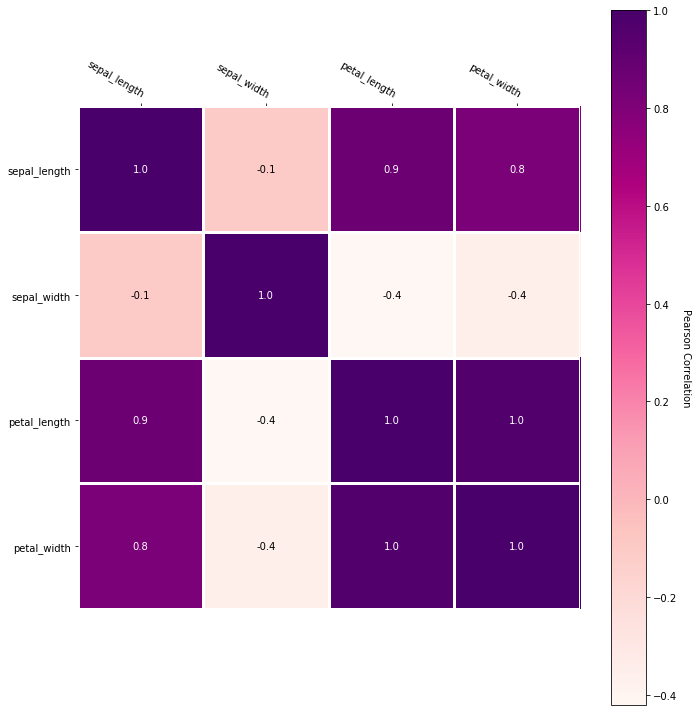

In [6]:
fig, ax = plt.subplots(figsize=(10,10))

im, cbar = heatmap(corr_mat, feature_cols, feature_cols, ax=ax,
                         cmap="RdPu", cbarlabel="Pearson Correlation")

texts = annotate_heatmap(im, valfmt="{x:.1f}")

fig.tight_layout()
plt.show()

In [7]:
train_df, test_df = features_df.randomSplit([0.75, 0.25], seed=7)
train_df.count(), test_df.count()

(103, 47)

# K-means

In [8]:

from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(train_df)

train_df = scalerModel.transform(train_df)
test_df = scalerModel.transform(test_df)

train_df.show(5)      
test_df.show(5)

+------------+-----------+------------+-----------+-------+--------------------+--------------------+
|sepal_length|sepal_width|petal_length|petal_width|species|   features_unscaled|            features|
+------------+-----------+------------+-----------+-------+--------------------+--------------------+
|         4.4|        2.9|         1.4|        0.2| setosa|[4.40000009536743...|[-1.7125590665378...|
|         4.4|        3.0|         1.3|        0.2| setosa|[4.40000009536743...|[-1.7125590665378...|
|         4.4|        3.2|         1.3|        0.2| setosa|[4.40000009536743...|[-1.7125590665378...|
|         4.5|        2.3|         1.3|        0.3| setosa|[4.5,2.2999999523...|[-1.5942536154373...|
|         4.6|        3.1|         1.5|        0.2| setosa|[4.59999990463256...|[-1.4759481643368...|
+------------+-----------+------------+-----------+-------+--------------------+--------------------+
only showing top 5 rows

+------------+-----------+------------+-----------+------

# WSSE for predicting K value

Trying k from 2 to 7 with 53 samples...

Training for cluster size 2 
......................WSSE = 57.83606823612324 
Training for cluster size 3 
......................WSSE = 51.23293215218001 
Training for cluster size 4 
......................WSSE = 40.125315215189026 
Training for cluster size 5 
......................WSSE = 39.89589200062628 
Training for cluster size 6 
......................WSSE = 34.96720595739931 
Training for cluster size 7 
......................WSSE = 30.779303348997672 


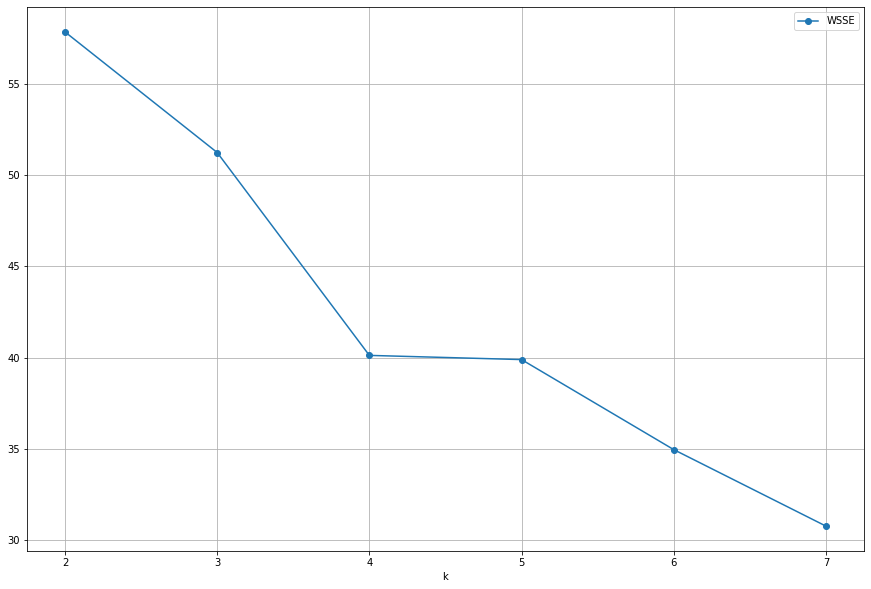

In [9]:
# Only need to run this once to find value(s) to try for k
create_elbow_plot = True # Set to False if already know value for k


if create_elbow_plot == True:
    # lower the sample fraction to decrease fit time (with the risk of worse results)
    sampled = train_df.sample(.5)

    k_attempts = range(2,8)
    print('Trying k from {} to {} with {} samples...\n'.format(list(k_attempts)[0],
                                                               list(k_attempts)[-1],
                                                               sampled.count()))

    wsseList = elbow(sampled, k_attempts)
    elbow_plot(wsseList, k_attempts)
    
    



# Silhouete score

In [10]:
kmeans = KM(k = 3 , seed = 7)
model = kmeans.fit(train_df)
transformed = model.transform(train_df)
featuresAndPrediction = transformed.select("features", "prediction")

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(transformed)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.6333037424601361
Cluster Centers: 
[-0.04952099 -0.84728469  0.34632473  0.31347547]
[-0.97643565  0.76750836 -1.25025922 -1.22223739]
[1.15265369 0.06327073 1.02774895 1.03215327]


# Bisecting k-means

In [11]:
from pyspark.ml.clustering import BisectingKMeans

# Trains a bisecting k-means model.
bkm = BisectingKMeans().setK(3).setSeed(7)
model = bkm.fit(train_df)

# Evaluate clustering.
cost = model.computeCost(train_df)
print("Within Set Sum of Squared Errors = " + str(cost))

# Shows the result.
print("Cluster Centers: ")
centers = model.clusterCenters()
for center in centers:
    print(center)

Within Set Sum of Squared Errors = 407.9999999999996
Cluster Centers: 
[ 3.40612112e-15  2.91891646e-15 -5.34631670e-16  2.67315835e-16]


# Gaussian Mixture Model (GMM)

In [12]:
from pyspark.ml.clustering import GaussianMixture

gmm = GaussianMixture().setK(3).setSeed(7)
model = gmm.fit(train_df)

print("Gaussians shown as a DataFrame: ")
model.gaussiansDF.show(truncate=False)

Gaussians shown as a DataFrame: 
+-------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|mean                                                                                 |cov                                                                                                                                                                                                                                                                                                                                                                |
+------------------------------------------------------------------------------